<a href="https://colab.research.google.com/github/Rudi3601/CHC_Thesis/blob/main/Deep_Hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [1]:
#%tensorflow_version 1.x
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

#from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt

import copy

Initializing parameters

In [2]:
N=100 # time disrectization
S0=1 # initial value of the asset
T=1 # maturity
strike = 1.0 # f(S)=(S-1)_+ European Call Contract
sigma=0.2 # volatility in Black Scholes

Black-Scholes Model:

In [3]:
import scipy.stats as scipy
from scipy.stats import norm

#Blackscholes price

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

priceBS=BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

Price of a Call option in the Black scholes model with initial price 1 strike 1.0 maturity 1 and volatility 0.2 is equal to 0.07965567455405798


Definition of NN:

In [4]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [5]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0,
#the initial hedging being 0, and the increments of the log price process
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    strategyeval=hedgeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price)
outputs = Subtract()([payoff,hedge])
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge
outputs= [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

For Red-Nodes:

In [6]:
R=50 # reduction
# architecture is the same for all networks
layers_red = []
for j in range(R):
    for i in range(d):
        if i < d-1:
            nodes_red = n
            layer_red = Dense(nodes_red, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes_red = m
            layer_red = Dense(nodes_red, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers_red = layers_red + [layer_red]

for j in range(R,N):
    for i in range(d):
        if i < d-1:
            nodes_red = n
            layer_red = Dense(nodes_red, activation='tanh',trainable=False,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes_red = m
            layer_red = Dense(nodes_red, activation='linear', trainable=False,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers_red = layers_red + [layer_red]

In [7]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0,
#the initial hedging being 0, and the increments of the log price process
price_red = Input(shape=(m,))
hedge_red = Input(shape=(m,))
hedgeeval_red = Input(shape=(m,))
premium_red = Input(shape=(m,))

inputs_red = [price_red]+[hedge_red]+[hedgeeval_red]+[premium_red]
outputhelper_red=[]

premium_red = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium_red)

for j in range(N):
    strategy_red = price_red
    strategyeval_red=hedgeeval_red
    for k in range(d):
        strategy_red= layers_red[k+(j)*d](strategy_red) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval_red=layers_red[k+(j)*d](strategyeval_red)
    incr_red = Input(shape=(m,))
    logprice_red= Lambda(lambda x : K.log(x))(price_red)
    logprice_red = Add()([logprice_red, incr_red])
    pricenew_red=Lambda(lambda x : K.exp(x))(logprice_red)# creating the price at time j+1
    priceincr_red=Subtract()([pricenew_red, price_red])
    hedgenew_red = Multiply()([strategy_red, priceincr_red])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge_red = Add()([hedge_red,hedgenew_red]) # building up the discretized stochastic integral
    inputs_red = inputs_red + [incr_red]
    outputhelper_red = outputhelper_red + [strategyeval_red]
    price_red=pricenew_red
payoff_red= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price_red)
outputs_red = Subtract()([payoff_red,hedge_red])
outputs_red = Subtract()([outputs_red,premium_red]) # payoff minus price minus hedge
outputs_red= [outputs_red] + outputhelper_red +[premium_red]
outputs_red = Concatenate()(outputs_red)

model_hedge_strat_red = Model(inputs=inputs_red, outputs=outputs_red)

In [8]:
gamma = 1.0
grid = [(i/N)**gamma*T for i in range(N+1)]

Ktrain = 10**5
initialprice = S0

# xtrain consists of the price S0,
#the initial hedging being 0, and the increments of the log price process
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [priceBS*np.ones((Ktrain,m))]+
          [np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]),sigma*np.sqrt(grid[i+1]-grid[i]),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [9]:
N_red=1000
xtrain_red=copy.deepcopy(xtrain)
for i in range(R):
    a = xtrain_red[4+i]
    for k in range(int(Ktrain/N_red)):
        for l in range(N_red):
            a[k*N_red+l,:]=a[k*N_red,:]
    xtrain_red[4+i]=a

In [10]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.square(z))
    return z

In [11]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)
model_hedge_strat_red.compile(optimizer='adam',loss=custom_loss)

In [12]:
import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True,batch_size=100)
weights = model_hedge_strat.get_weights()
model_hedge_strat_red.set_weights(weights)
#for i in range(5):
#    model_hedge_strat_red.fit(x=xtrain_red,y=ytrain, epochs=1,verbose=True,batch_size=10000)
#weights = model_hedge_strat_red.get_weights()
#model_hedge_strat.set_weights(weights)

1000/1000 [==============================] - 52s 52ms/step - loss: 1.6050e-04


3125/3125 [==============================] - 54s 15ms/step


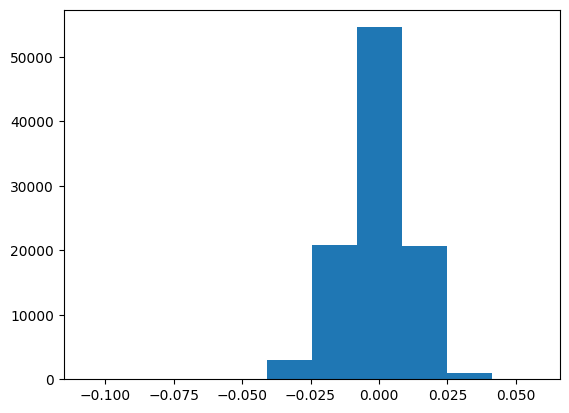

0.011612371
0.08028693


In [13]:
a = model_hedge_strat.predict(xtrain)
plt.hist(a[:,0])
plt.show()
print(np.std(a[:,0]))
print(np.mean(a[:,N+1]))

In [14]:
Ktest=50
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [0.5*np.ones((Ktest,m))+np.cumsum(np.ones((Ktest,m))*(1.5-0.5)/Ktest,axis=0)] +#change this if you go to higher dimensions
          [priceBS*np.ones((Ktest,m))]+
          [np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]),sigma*np.sqrt(grid[i+1]-grid[i]),(Ktest,m)) for i in range(N)])

y=model_hedge_strat.predict(xtest)[:,10]
print(y)

2/2 [==============================] - 5s 21ms/step
[-0.3423095  -0.31506276 -0.28685215 -0.25768748 -0.22758105 -0.19654733
 -0.1646038  -0.13176852 -0.09806506 -0.0635188  -0.02816198  0.00796597
  0.04481652  0.08233076  0.12043788  0.15905225  0.19807604  0.2373982
  0.2768937   0.31642777  0.35585788  0.39503425  0.4338064   0.4720244
  0.50954396  0.5462278   0.5819505   0.61660105  0.6500828   0.6823167
  0.71324056  0.74280995  0.7709964   0.7977877   0.8231855   0.8472032
  0.8698658   0.89120704  0.9112675   0.93009394  0.94773674  0.9642495
  0.9796869   0.994105    1.0075593   1.0201048   1.0317951   1.0426819
  1.0528154   1.0622435 ]


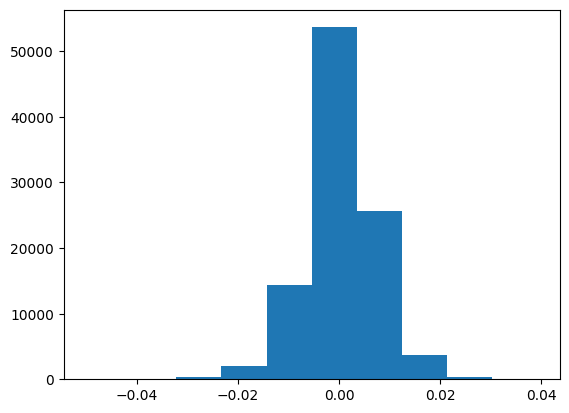

0.006884323120714913
0.00036652911733968684


In [15]:
logincrements = xtrain[4:4+N]
hedge = np.zeros(Ktrain)
price = S0*np.ones((Ktrain,N))
for k in range(N-1):
    helper = logincrements[k][:,]
    helper = helper.transpose()
    price[:,k+1] = price[:,k]*np.exp(helper[:])
    hedge[:] = hedge[:] + scipy.norm.cdf((np.log(price[:,k]/strike)+0.5*(T-grid[k+1])*sigma**2)/(np.sqrt(T-grid[k+1])*sigma))*(price[:,k+1]-price[:,k])
hedge[:]= hedge[:]-0.5*(np.abs(price[:,N-1]-strike)+(price[:,N-1]-strike))+priceBS
plt.hist(hedge)
plt.show()
print(np.std(hedge))
print(np.mean(hedge))

2/2 [==============================] - 0s 19ms/step


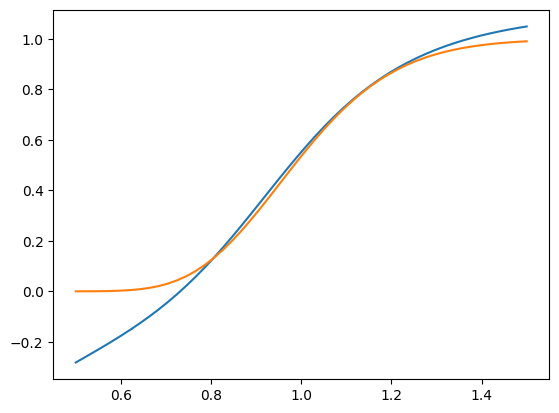

In [16]:
l =20
s=np.linspace(0.5,1.5,Ktest)
z=scipy.norm.cdf((np.log(s/strike)+0.5*(T-grid[l])*sigma**2)/(np.sqrt(T-grid[l])*sigma))
#plt.plot(s,z)
#plt.plot(s,y)
y=model_hedge_strat.predict(xtest)[:,l]
plt.plot(s,y,s,z)
plt.show()

In [17]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 8  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [18]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0,
#the initial hedging being 0, and the increments of the log price process
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=False,
                kernel_initializer=initializers.RandomNormal(1.0,0.0),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0.0,0.0))(premium)

for j in range(N):
    strategy = Concatenate()([price,premium])
    strategyeval=Concatenate()([hedgeeval,premium])
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price)
outputs = Subtract()([payoff,hedge])
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge
outputs= [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [19]:
Ktrain = 10**5
initialprice = S0

# xtrain consists of the price S0,
#the initial hedging being 0, and the increments of the log price process
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [priceBS*np.linspace(0.5,1.5,Ktrain)]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [20]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.exp(-z))
    return z


In [21]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)

3125/3125 [==============================] - 54s 15ms/step


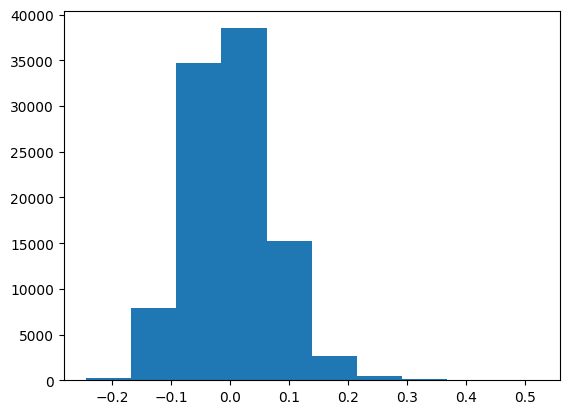

3125/3125 [==============================] - 52s 17ms/step
0.07044798
3125/3125 [==============================] - 48s 15ms/step
0.07965567


In [22]:
import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)
plt.hist(model_hedge_strat.predict(xtrain)[:,0])
plt.show()
print(np.std(model_hedge_strat.predict(xtrain)[:,0]))
print(np.mean(model_hedge_strat.predict(xtrain)[:,N+1]))